# Metric-Aware Neighborhood Aggregation (MANA)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors

import scanpy as sc
import squidpy as sq
import cellcharter as cc
import scvi

from pandas.api.types import is_numeric_dtype, is_categorical_dtype
from scipy.sparse import issparse


# ------------------------------------------------------------------
# 1) Define and apply course + region + sample_id order
# ------------------------------------------------------------------
course_order = [
    "MOG CFA",
    "early onset",
    "chronic peak",
    "chronic long",

    "PLP CFA",
    "non symptomatic",
    "monophasic",

    "onset I",
    "onset II",
    "peak I",
    "remitt I",
    "peak II",
    "remitt II",
    "peak III",
]

region_order = ["L", "T", "C"]


def apply_course_region_and_sample_order(ad, sample_key="sample_id"):
    """Make ad.obs['course'], ad.obs['region'], and ad.obs[sample_key] ordered categoricals."""
    # --- course ---
    if "course" in ad.obs.columns:
        ad.obs["course"] = ad.obs["course"].astype(
            pd.CategoricalDtype(categories=course_order, ordered=True)
        )

    # --- region ---
    if "region" in ad.obs.columns:
        ad.obs["region"] = ad.obs["region"].astype(
            pd.CategoricalDtype(categories=region_order, ordered=True)
        )

    # --- sample_id ordered by (course, region, sample_id) ---
    if (
        sample_key in ad.obs.columns
        and "course" in ad.obs.columns
        and "region" in ad.obs.columns
    ):
        tmp = (
            ad.obs[[sample_key, "course", "region"]]
            .drop_duplicates()
            .dropna(subset=["course", "region"])
            .copy()
        )

        tmp["course"] = tmp["course"].astype(
            pd.CategoricalDtype(categories=course_order, ordered=True)
        )
        tmp["region"] = tmp["region"].astype(
            pd.CategoricalDtype(categories=region_order, ordered=True)
        )

        tmp = tmp.sort_values(["course", "region", sample_key])
        sample_order = tmp[sample_key].tolist()

        ad.obs[sample_key] = ad.obs[sample_key].astype(
            pd.CategoricalDtype(categories=sample_order, ordered=True)
        )

        ad.uns[f"{sample_key}_order_by_course_region"] = sample_order

    return ad


# ------------------------------------------------------------------
# 2) Plot function (obs + genes, ordered groupby, shared vmin/vmax)
# ------------------------------------------------------------------
def plot_spatial_compact_fast(
    ad,
    color="leiden_2",       # obs column *or* gene name
    groupby="sample_id",
    spot_size=8,
    cols=3,
    height=8,
    legend_col_width=1.2,
    palette=None,
    rasterized=True,
    invert_y=True,
    dpi=120,
    highlight=None,
    group_order=None,
    background="white",
    grey_alpha=0.2,         # alpha for non-highlighted categories
    vmin=None,
    vmax=None,
    cmap_name="viridis",
    shared_scale=False,     # if True: vmin/vmax from whole `ad` (not per subset)
):
    # pick background + text color
    fig_face = background
    ax_face = background
    text_color = "white" if background in ("black", "#000000", "k") else "black"

    # ----- 0) Preconditions -----
    if "spatial" not in ad.obsm:
        raise ValueError("ad.obsm['spatial'] not found")

    if groupby not in ad.obs.columns:
        raise KeyError(f"groupby {groupby!r} not in ad.obs")

    # decide where 'color' comes from: obs vs var (gene)
    if color in ad.obs.columns:
        color_source = "obs"
        col_series = ad.obs[color]
    elif color in ad.var_names:
        color_source = "var"   # gene expression
        col_series = None
    else:
        raise KeyError(
            f"{color!r} not found in ad.obs.columns or ad.var_names "
            "(expected an obs column or a gene name)."
        )

    coords = np.asarray(ad.obsm["spatial"])[:, :2]

    # Detect continuous vs categorical
    if color_source == "var":
        # genes: always continuous
        is_continuous = True
    else:
        if is_categorical_dtype(col_series):
            is_continuous = False
        else:
            is_continuous = is_numeric_dtype(col_series)

    # ----------------------------------------------------
    # 1) Build colors_arr differently for cont vs cat
    # ----------------------------------------------------
    if is_continuous:
        # ===== CONTINUOUS MODE =====
        if color_source == "obs":
            vals = col_series.to_numpy(dtype=float)
        else:
            # from var / gene expression
            gene_idx = ad.var_names.get_loc(color)
            x = ad.X[:, gene_idx]
            if issparse(x):
                vals = x.toarray().ravel()
            else:
                vals = np.asarray(x).ravel()

        # choose colormap
        if palette is None:
            cmap = plt.get_cmap(cmap_name)
        elif isinstance(palette, str):
            cmap = plt.get_cmap(palette)
        else:
            cmap = palette

        # ----- determine vmin/vmax -----
        if shared_scale:
            # global min/max across the *full AnnData* passed to this function
            full = ad
            if color_source == "var":
                gx = full.X[:, full.var_names.get_loc(color)]
                if issparse(gx):
                    full_vals = gx.toarray().ravel()
                else:
                    full_vals = np.asarray(gx).ravel()
            else:
                full_vals = pd.to_numeric(full.obs[color], errors="coerce").to_numpy()

            finite_full = np.isfinite(full_vals)
            if finite_full.sum() == 0:
                raise ValueError(f"All values for '{color}' are NaN or non-finite.")
            vmin_use = float(np.min(full_vals[finite_full]))
            vmax_use = float(np.max(full_vals[finite_full]))
        else:
            finite_mask = np.isfinite(vals)
            if finite_mask.sum() == 0:
                raise ValueError(f"All values for '{color}' are NaN or non-finite.")
            vmin_use = float(np.min(vals[finite_mask]))
            vmax_use = float(np.max(vals[finite_mask]))

        # user overrides everything
        if vmin is not None:
            vmin_use = float(vmin)
        if vmax is not None:
            vmax_use = float(vmax)

        # avoid zero-range
        if vmin_use == vmax_use:
            vmin_use -= 1.0
            vmax_use += 1.0

        norm = mcolors.Normalize(vmin=vmin_use, vmax=vmax_use)

        colors_arr = np.zeros((vals.size, 4), dtype=float)
        finite_mask = np.isfinite(vals)
        colors_arr[finite_mask] = cmap(norm(vals[finite_mask]))
        colors_arr[~finite_mask] = (0, 0, 0, 0)

        # store continuous settings in uns (also fine for genes)
        ad.uns[f"{color}_continuous"] = {
            "vmin": float(vmin_use),
            "vmax": float(vmax_use),
            "cmap": cmap.name if hasattr(cmap, "name") else str(cmap),
        }

        cat_names = None
        cat_codes = None

    else:
        # ===== CATEGORICAL (only for obs) =====
        # preserve existing categorical order if present
        if is_categorical_dtype(col_series):
            cats = col_series.cat.remove_unused_categories()
        else:
            cats = col_series.astype("category")

        cat_names = cats.cat.categories
        cat_codes = cats.cat.codes.to_numpy()

        # palette handling
        if isinstance(palette, dict):
            col_list = [palette[c] for c in cat_names]
        elif isinstance(palette, (list, tuple)):
            if len(palette) < len(cat_names):
                raise ValueError("Palette shorter than number of categories.")
            col_list = list(palette)[:len(cat_names)]
        elif f"{color}_colors" in ad.uns:
            col_list = list(ad.uns[f"{color}_colors"])
            if len(col_list) != len(cat_names):
                raise ValueError(f"{color}_colors length != categories.")
        else:
            base = list(
                sc.pl.palettes.default_64
                if hasattr(sc.pl.palettes, "default_64")
                else sc.pl.palettes.default_102
            )
            reps = int(np.ceil(len(cat_names) / len(base)))
            col_list = (base * reps)[:len(cat_names)]

        ad.uns[f"{color}_colors"] = col_list

        rgba = np.array([mcolors.to_rgba(c) for c in col_list], dtype=float)

        colors_arr = np.empty((cat_codes.size, 4), dtype=float)
        colors_arr[cat_codes >= 0] = rgba[cat_codes[cat_codes >= 0]]
        colors_arr[cat_codes < 0] = (0, 0, 0, 0)

        # ----- highlighting logic -----
        if highlight is not None:
            # allow single value or list/tuple/array
            if not isinstance(highlight, (list, tuple, set, np.ndarray)):
                highlight = [highlight]
            # convert to string for robust matching
            highlight_str = {str(h) for h in highlight}

            cat_name_str = np.array([str(c) for c in cat_names])
            keep_cat_mask = np.isin(cat_name_str, list(highlight_str))  # per-category

            # use user-defined alpha for greyed-out categories
            grey_rgba = (0.8, 0.8, 0.8, float(grey_alpha))

            valid = cat_codes >= 0
            keep_flag = np.zeros_like(cat_codes, dtype=bool)
            keep_flag[valid] = keep_cat_mask[cat_codes[valid]]

            # grey out all non-highlighted cells
            colors_arr[valid & ~keep_flag] = grey_rgba

            # also grey in legend
            col_list = [
                col_list[k] if keep_cat_mask[k] else mcolors.to_hex(grey_rgba)
                for k in range(len(cat_names))
            ]

    # ----------------------------------------------------
    # 2) Precompute group indices (RESPECT ORDERED CATEGORICAL)
    # ----------------------------------------------------
    gser = ad.obs[groupby]

    if group_order is not None:
        group_order = [str(g) for g in group_order]
        present = set(gser.astype(str))
        uniq_groups = [g for g in group_order if g in present]
    else:
        # if groupby is an ordered categorical, respect its category order
        if is_categorical_dtype(gser) and gser.cat.ordered:
            cats = list(gser.cat.categories)
            present = set(gser.astype(str))
            uniq_groups = [str(c) for c in cats if str(c) in present]
        else:
            # fallback: sorted unique strings
            uniq_groups = sorted(gser.astype(str).unique())

    gvals = gser.astype(str).to_numpy()
    gid_to_idx = {g: i for i, g in enumerate(uniq_groups)}
    gcodes = np.array([gid_to_idx.get(g, -1) for g in gvals], dtype=int)

    group_indices = [np.flatnonzero(gcodes == gi) for gi in range(len(uniq_groups))]

    # ----------------------------------------------------
    # 3) Figure layout
    # ----------------------------------------------------
    n = len(uniq_groups)
    rows = int(np.ceil(n / cols))
    panel_w = height * cols * 0.6 / rows
    fig_w = panel_w + legend_col_width

    plt.ioff()
    fig = plt.figure(figsize=(fig_w, height), dpi=dpi, constrained_layout=False)

    # background for figure
    fig.patch.set_facecolor(fig_face)

    gs = GridSpec(
        rows, cols + 1, figure=fig,
        width_ratios=[1]*cols + [legend_col_width / (fig_w - legend_col_width)],
        wspace=0.02, hspace=0.02
    )

    # ----------------------------------------------------
    # 4) Panels
    # ----------------------------------------------------
    for i, sid in enumerate(uniq_groups):
        r, c = divmod(i, cols)
        ax = fig.add_subplot(gs[r, c])

        # panel background
        ax.set_facecolor(ax_face)

        idx = group_indices[i]
        if idx.size:
            xy = coords[idx]
            ax.scatter(
                xy[:, 0], -xy[:, 1],
                c=colors_arr[idx],
                s=spot_size,
                marker='o',
                linewidths=0,
                rasterized=rasterized
            )

        meta_strings = []

        if "region" in ad.obs.columns:
            region_vals = (
                ad.obs.loc[ad.obs[groupby] == sid, "region"]
                .dropna().astype(str).unique()
            )
            if len(region_vals) == 0:
                meta_strings.append("Region: unknown")
            elif len(region_vals) == 1:
                meta_strings.append(f"Region: {region_vals[0]}")
            else:
                meta_strings.append("Region: mixed")

        if "course" in ad.obs.columns:
            course_vals = (
                ad.obs.loc[ad.obs[groupby] == sid, "course"]
                .dropna().astype(str).unique()
            )
            if len(course_vals) == 0:
                meta_strings.append("Course: unknown")
            elif len(course_vals) == 1:
                meta_strings.append(f"Course: {course_vals[0]}")
            else:
                meta_strings.append("Course: mixed")

        if meta_strings:
            title = f"{sid}\n[{ ' | '.join(meta_strings) }]"
        else:
            title = str(sid)

        ax.set_title(title, fontsize=5, pad=2, color=text_color)
        ax.set_aspect("equal")
        if invert_y:
            ax.invert_yaxis()
        ax.set_axis_off()

    # blank unused panels
    for j in range(n, rows * cols):
        r, c = divmod(j, cols)
        ax = fig.add_subplot(gs[r, c])
        ax.set_facecolor(ax_face)
        ax.axis("off")

    # ----------------------------------------------------
    # 5) Legend / Colorbar
    # ----------------------------------------------------
    ax_leg = fig.add_subplot(gs[:, -1])
    ax_leg.set_facecolor(ax_face)
    ax_leg.axis("off")

    if is_continuous:
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=ax_leg)
        cbar.set_label(color, rotation=90, color=text_color)
        cbar.ax.yaxis.set_tick_params(color=text_color)
        plt.setp(plt.getp(cbar.ax.axes, "yticklabels"), color=text_color)
    else:
        handles = [
            Line2D(
                [0], [0], marker="o", color="w",
                markerfacecolor=col_list[k], markersize=7, label=str(cat)
            )
            for k, cat in enumerate(cat_names)
        ]
        leg = ax_leg.legend(
            handles=handles,
            title=color,
            frameon=False,
            loc="center left",
            labelcolor=text_color,
            title_fontsize=10
        )
        leg.get_title().set_color(text_color)
        for text in leg.get_texts():
            text.set_color(text_color)

    fig.subplots_adjust(
        left=0.01, right=0.98, top=0.98, bottom=0.02,
        wspace=0.02, hspace=0.02
    )

    plt.ion()
    plt.show()


In [2]:
import scanpy as sc
import sys
print(sys.version)
print(sys.executable)

3.11.14 | packaged by conda-forge | (main, Oct 22 2025, 22:56:31) [Clang 19.1.7 ]
/Users/chrislangseth/miniforge3/envs/cellcharter/bin/python


In [3]:
basedir = '/Volumes/processing2/RRmap/data/'

In [4]:
ad = sc.read_h5ad(basedir + 'EAE_proseg_clustered_louvain_leiden_all_sections_annotated_rotated_cellcharter_neigh2_251219.h5ad')

# subset for testing

In [5]:
samples = ['S3_B3_0','S1_T3_1','G4_L2_0','S2_T1_1','S1_B3_2','S1_T1_0','S1_B1_2', 'S3_B3_0', 'G3_L1_1', 'S4_B3_0']

In [6]:
ad_sub = ad[ad.obs.sample_id.isin(samples)]

In [7]:
ad_sub.X.max()

np.int64(1158)

In [8]:
ad_sub = ad_sub.copy()

In [9]:
ad_sub.layers['counts'] = ad_sub.X

In [10]:
scvi.model.SCVI.setup_anndata(
    ad_sub, 
    layer="counts", 
)

model = scvi.model.SCVI(ad_sub)

In [12]:
model.train(early_stopping=True, max_epochs = 20, enable_progress_bar=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


Epoch 20/20: 100%|█| 20/20 [09:39<00:00, 29.80s/it, v_num=1, train_loss=2.26e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [09:39<00:00, 28.97s/it, v_num=1, train_loss=2.26e+3]


In [13]:
ad_sub.obsm['X_scVI'] = model.get_latent_representation(ad_sub).astype(np.float32)

In [14]:
ad_sub

AnnData object with n_obs × n_vars = 107228 × 5101
    obs: 'cell', 'centroid_x', 'centroid_y', 'centroid_z', 'component', 'volume', 'surface_area', 'scale', 'region', 'sample_id', 'proseg_cluster', 'output_folder', 'Num', 'n_genes', 'n_counts', 'louvain_0.5', 'louvain_1', 'louvain_1.5', 'louvain_2', 'louvain_2.5', 'louvain_3', 'louvain_3.5', 'Cluster', 'Level1', 'Level2', 'Level3', 'Level3.1', 'grid_label', 'rbd_domain', 'rbd_domain_0.1', 'rbd_domain_0.2', 'rbd_domain_0.3', 'rbd_domain_0.5', 'rbd_domain_0.6', 'rbd_domain_0.7', 'rbd_domain_0.8', 'rbd_domain_0.9', 'rbd_domain_1.1', 'rbd_domain_1', 'rbd_domain_1.25', 'rbd_domain_1.4', 'rbd_domain_1.5', 'leiden_0.5', 'leiden_1', 'leiden_1.5', 'leiden_2', 'leiden_2.5', 'leiden_3', 'leiden_3.5', 'sample_name', 'course', 'condition', 'model', 'cytetype_annotation_louvain_3.5', 'cytetype_cellOntologyTerm_louvain_3.5', 'cluster_id', 'author_label', 'annotation', 'Class', 'state', 'CL_term', 'CL_term_id', 'confidence', 'author_label_similarity_

In [15]:
sq.gr.spatial_neighbors(ad_sub, library_key='sample_id', 
                        coord_type='generic', 
                        delaunay=True, 
                        spatial_key='spatial', 
                        percentile=99)

In [17]:
cc.gr.aggregate_neighbors(ad_sub, n_layers=3, use_rep='X_scVI', out_key='X_cellcharter', sample_key='sample_id')

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Epoch 2/20:   5%| | 1/20 [14:58<4:44:27, 898.32s/it, v_num=1, train_loss=2.46e+3

 11%|█████                                        | 1/9 [00:00<00:03,  2.16it/s]

100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  5.59it/s]


In [26]:
ad_sub.obsm['X_scVI']

array([[-0.46546096, -0.30052304,  1.2666986 , ..., -0.05499664,
         0.17339772,  1.6271306 ],
       [ 0.5335362 ,  0.8184515 , -1.0191095 , ...,  1.0441504 ,
         2.1787403 ,  2.5360942 ],
       [-0.20217068, -0.5845494 ,  0.8859555 , ..., -0.83103585,
         0.50063926,  0.8895104 ],
       ...,
       [ 0.06458709, -0.24665082,  1.054545  , ..., -0.64930797,
        -0.44363356,  0.7721838 ],
       [ 0.78234804,  0.48248065,  1.7049849 , ..., -0.68173933,
        -0.49174026,  1.1907699 ],
       [ 0.7357987 ,  0.24690711,  1.7134156 , ..., -0.66662073,
        -0.5741392 ,  0.8600309 ]], shape=(107228, 10), dtype=float32)

In [27]:
ad_sub.obsm['X_cellcharter']

array([[-0.46546096, -0.30052304,  1.2666986 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.5335362 ,  0.8184515 , -1.0191095 , ..., -0.6081161 ,
         1.1656028 ,  1.2910455 ],
       [-0.20217068, -0.5845494 ,  0.8859555 , ..., -0.974971  ,
         1.9528372 ,  1.6918983 ],
       ...,
       [ 0.06458709, -0.24665082,  1.054545  , ..., -0.62771827,
         0.18229273,  0.92241985],
       [ 0.78234804,  0.48248065,  1.7049849 , ..., -0.33008882,
         0.09533457,  0.8930574 ],
       [ 0.7357987 ,  0.24690711,  1.7134156 , ..., -0.40579385,
        -0.14964102,  0.936748  ]], shape=(107228, 40), dtype=float32)

In [18]:
ad_sub.obsm["X_cellcharter"] = ad_sub.obsm["X_cellcharter"].astype("float32")

In [20]:
from sklearn.cluster import MiniBatchKMeans

X = ad_sub.obsm["X_cellcharter"]

km = MiniBatchKMeans(
    n_clusters=15,
    random_state=0,
    batch_size=8192,
    n_init=10,
)

ad_sub.obs["CC_cluster"] = km.fit_predict(X).astype(str)

In [21]:
if "CC_cluster_colors" in ad_sub.uns:
    del ad_sub.uns["CC_cluster_colors"]

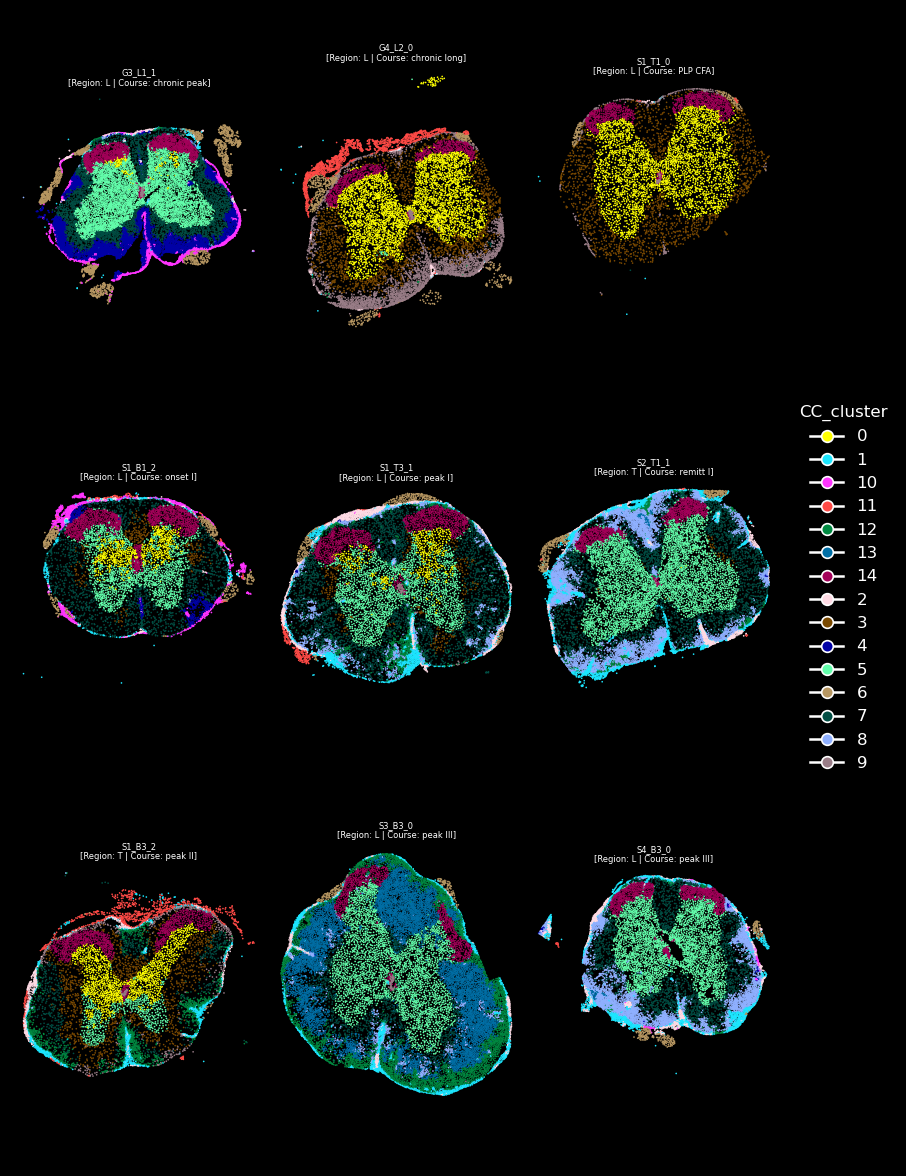

In [24]:
# usage
plot_spatial_compact_fast(
    ad_sub,
    color="CC_cluster",
    groupby="sample_id",
    spot_size=1,
    cols=3,
    height=10,
    legend_col_width=1.0,
    background="black",
    grey_alpha=0.05,
    #highlight=['4','5']
)

## what are the cluster representing? 

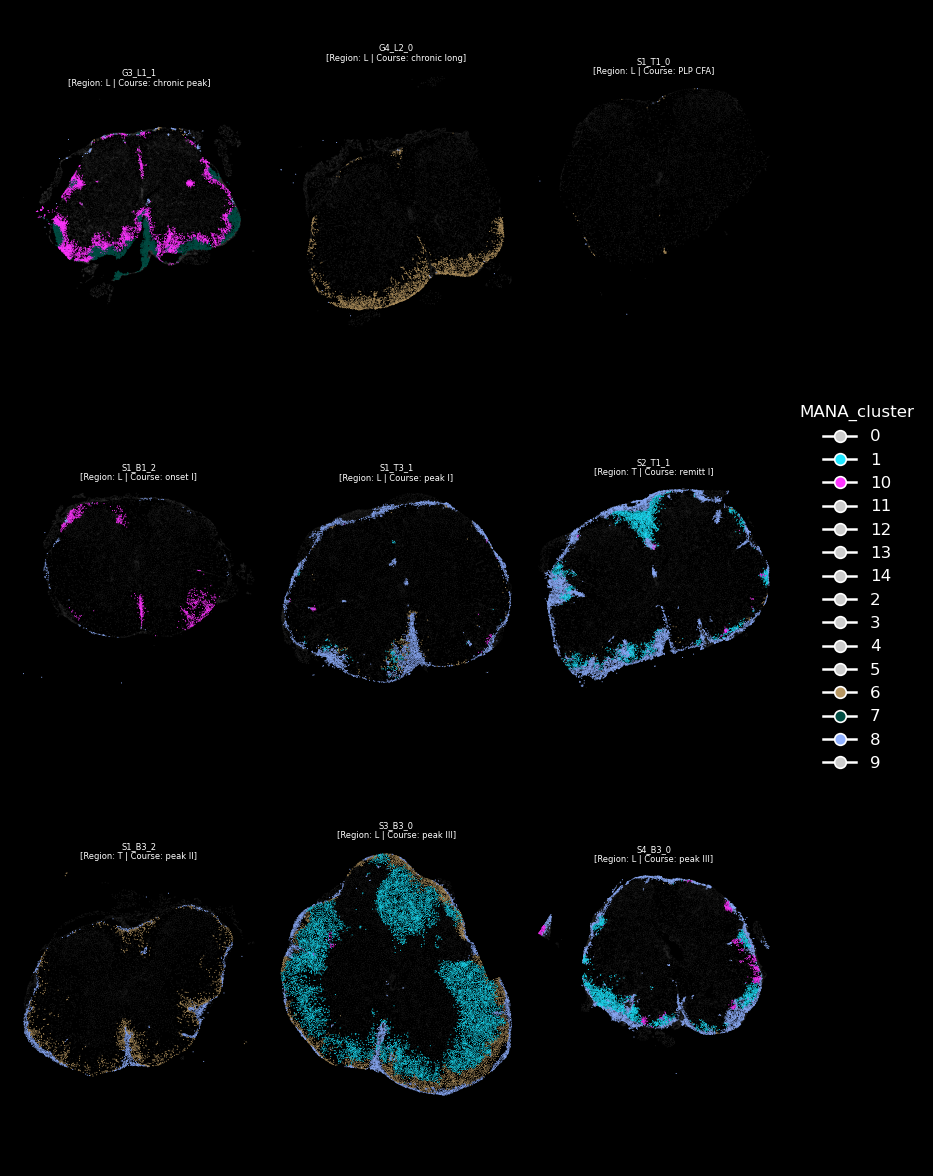

In [465]:
# usage
plot_spatial_compact_fast(
    ad_sub,
    color="MANA_cluster",
    groupby="sample_id",
    spot_size=0.4,
    cols=3,
    height=10,
    legend_col_width=1.0,
    background="black",
    grey_alpha=0.1,
    highlight=['7','1','8','6','10']
)

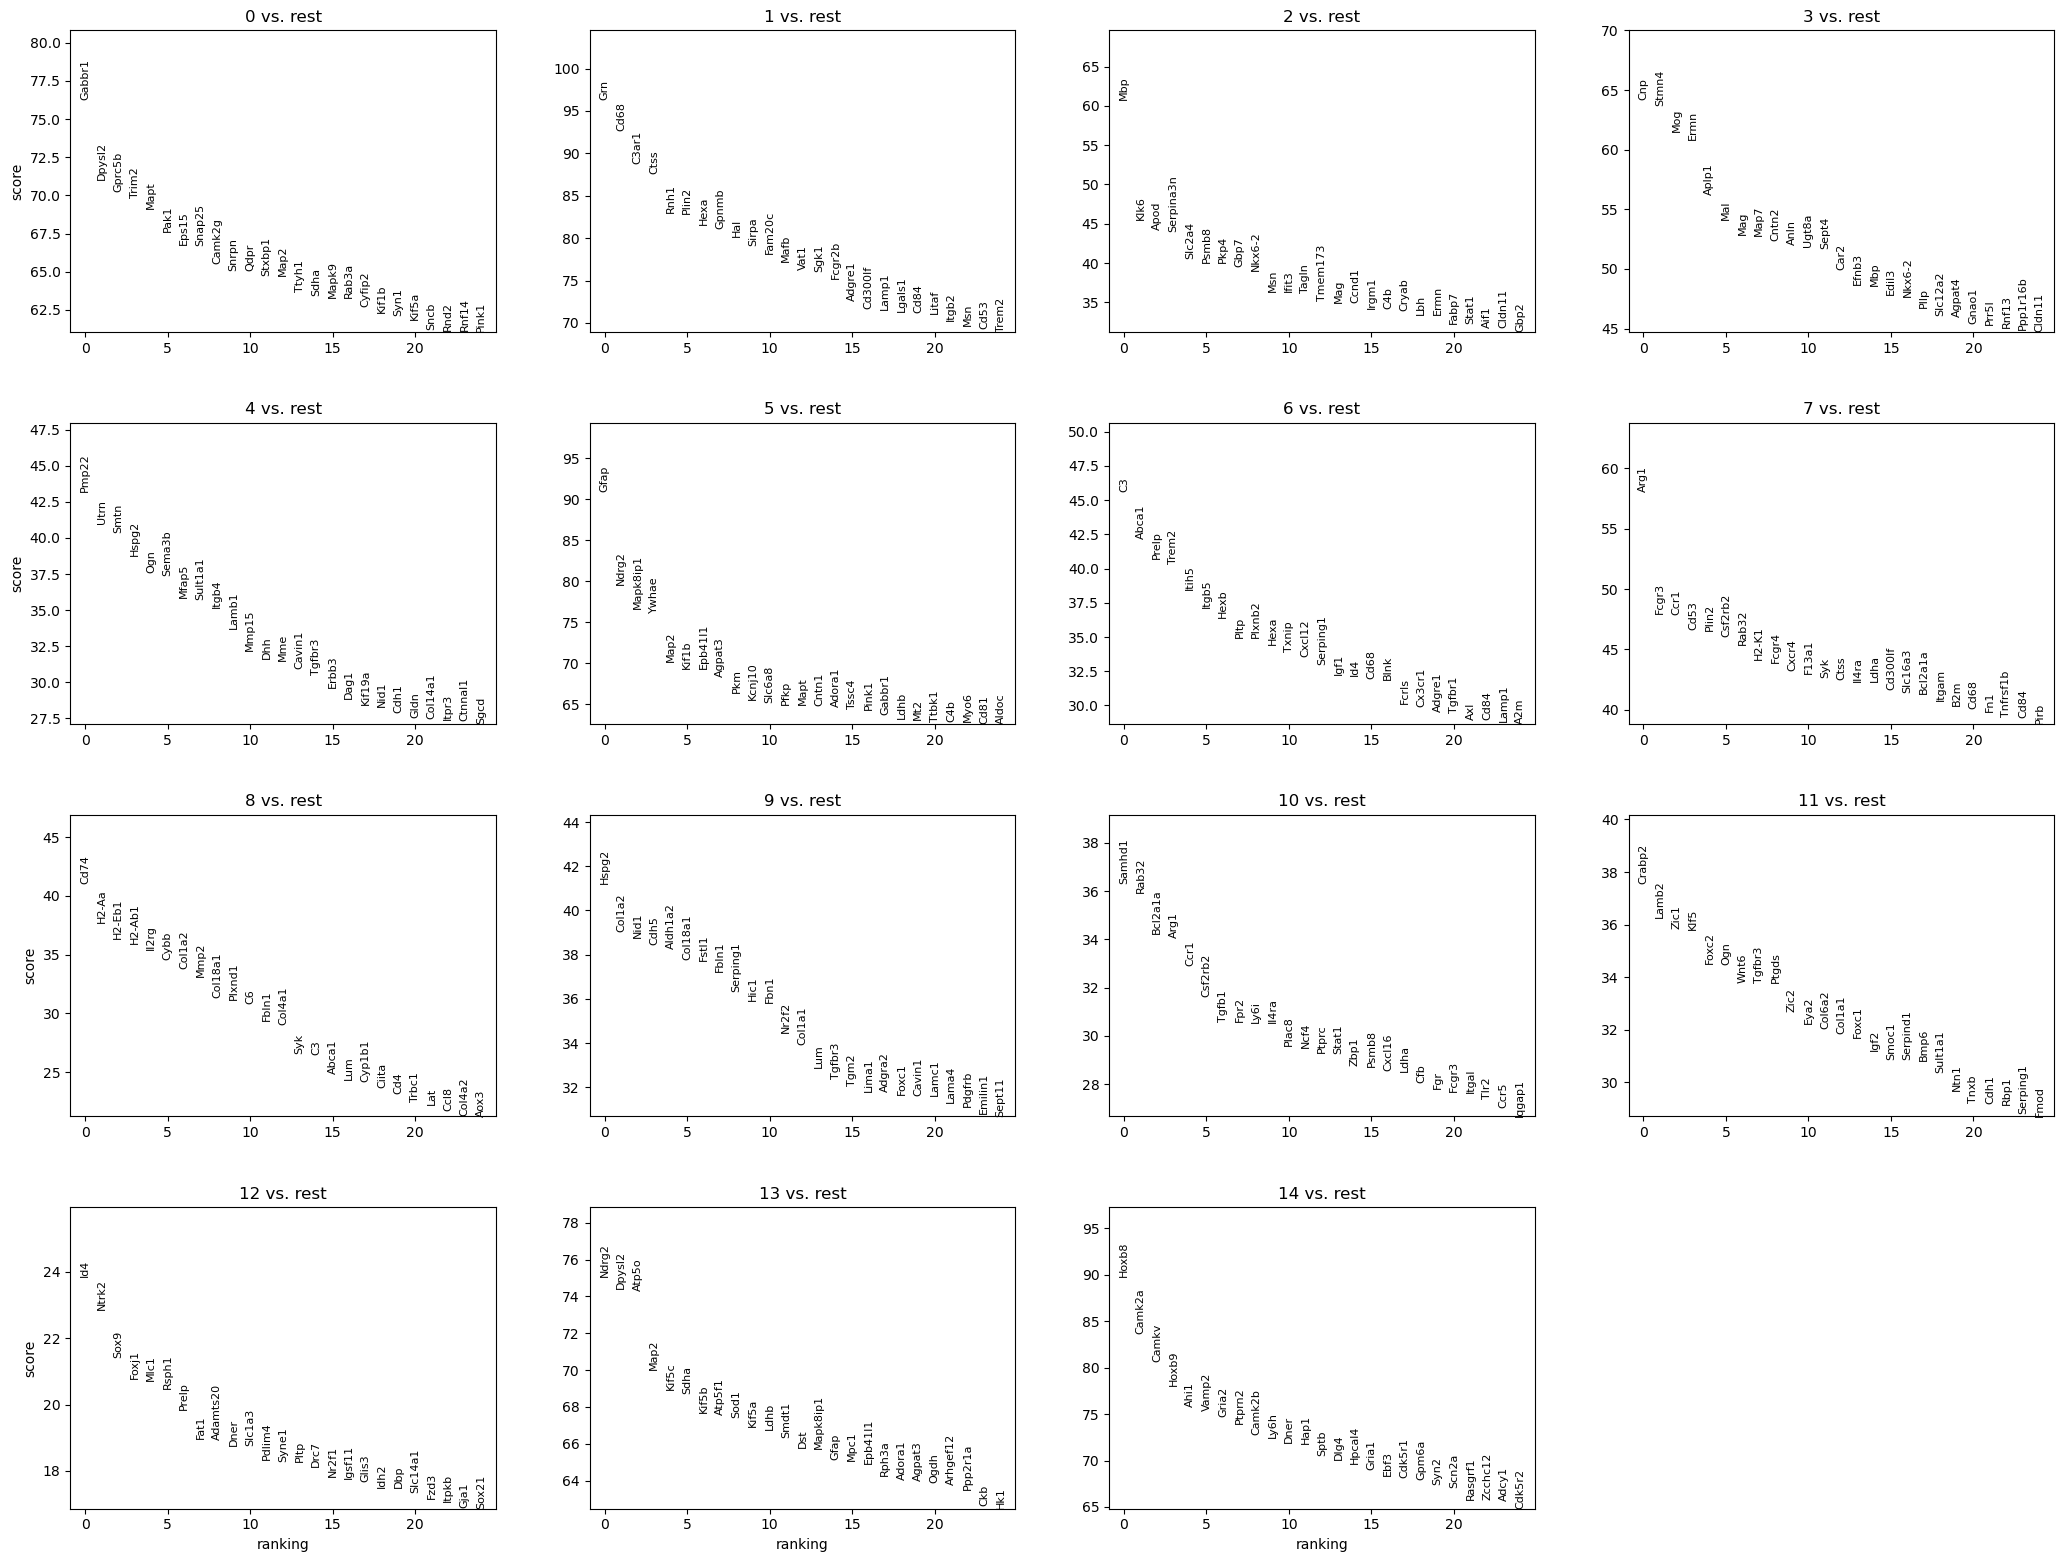

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,Gabbr1,76.250374,9.960303,0.0,0.0
1,0,Dpysl2,70.975624,8.888654,0.0,0.0
2,0,Gprc5b,70.215126,8.356975,0.0,0.0
3,0,Trim2,69.809929,5.999680,0.0,0.0
4,0,Mapt,69.087349,7.014956,0.0,0.0


In [472]:
# --- Find marker genes per cluster ---
sc.tl.rank_genes_groups(ad_sub, groupby="MANA_cluster", method="t-test")
sc.pl.rank_genes_groups(ad_sub, n_genes=25, sharey=False)

# get a tidy table of top markers
markers = sc.get.rank_genes_groups_df(ad_sub, group=None)
markers.head()

In [473]:
marker_genes = pd.DataFrame({
    group: ad_sub.uns['rank_genes_groups']['names'][group][:30]
    for group in ad_sub.uns['rank_genes_groups']['names'].dtype.names
})
for col in marker_genes.columns: 
    print(col)
    genes = marker_genes[col].tolist()
    print(" ".join(genes))
    print(' ')

0
Gabbr1 Dpysl2 Gprc5b Trim2 Mapt Pak1 Eps15 Snap25 Camk2g Snrpn Qdpr Stxbp1 Map2 Ttyh1 Sdha Mapk9 Rab3a Cyfip2 Kif1b Syn1 Kif5a Sncb Rnd2 Rnf14 Pink1 Glud1 Ppp2ca Kcnab2 Map1lc3a Dnm1
 
1
Grn Cd68 C3ar1 Ctss Rnh1 Plin2 Hexa Gpnmb Hal Sirpa Fam20c Mafb Vat1 Sgk1 Fcgr2b Adgre1 Cd300lf Lamp1 Lgals1 Cd84 Litaf Itgb2 Msn Cd53 Trem2 Pdia3 Gla Sdcbp Glmp Tnfsf13
 
2
Mbp Klk6 Apod Serpina3n Slc2a4 Psmb8 Pkp4 Gbp7 Nkx6-2 Msn Ifit3 Tagln Tmem173 Mag Ccnd1 Irgm1 C4b Cryab Lbh Ermn Fabp7 Stat1 Aif1 Cldn11 Gbp2 Gbp3 Anln Aldh1l2 Prr5l Klk8
 
3
Cnp Stmn4 Mog Ermn Aplp1 Mal Mag Map7 Cntn2 Anln Ugt8a Sept4 Car2 Efnb3 Mbp Edil3 Nkx6-2 Pllp Slc12a2 Agpat4 Gnao1 Prr5l Rnf13 Ppp1r16b Cldn11 Cpox Sept8 Myo1d Fgfr2 Sox8
 
4
Pmp22 Utrn Smtn Hspg2 Ogn Sema3b Mfap5 Sult1a1 Itgb4 Lamb1 Mmp15 Dhh Mme Cavin1 Tgfbr3 Erbb3 Dag1 Kif19a Nid1 Cdh1 Gldn Col14a1 Itpr3 Ctnnal1 Sgcd Lama2 Sox10 Egr2 Sostdc1 Col1a2
 
5
Gfap Ndrg2 Mapk8ip1 Ywhae Map2 Kif1b Epb41l1 Agpat3 Pkm Kcnj10 Slc6a8 Pfkp Mapt Cntn1 Adora1 Tssc4 Pink1

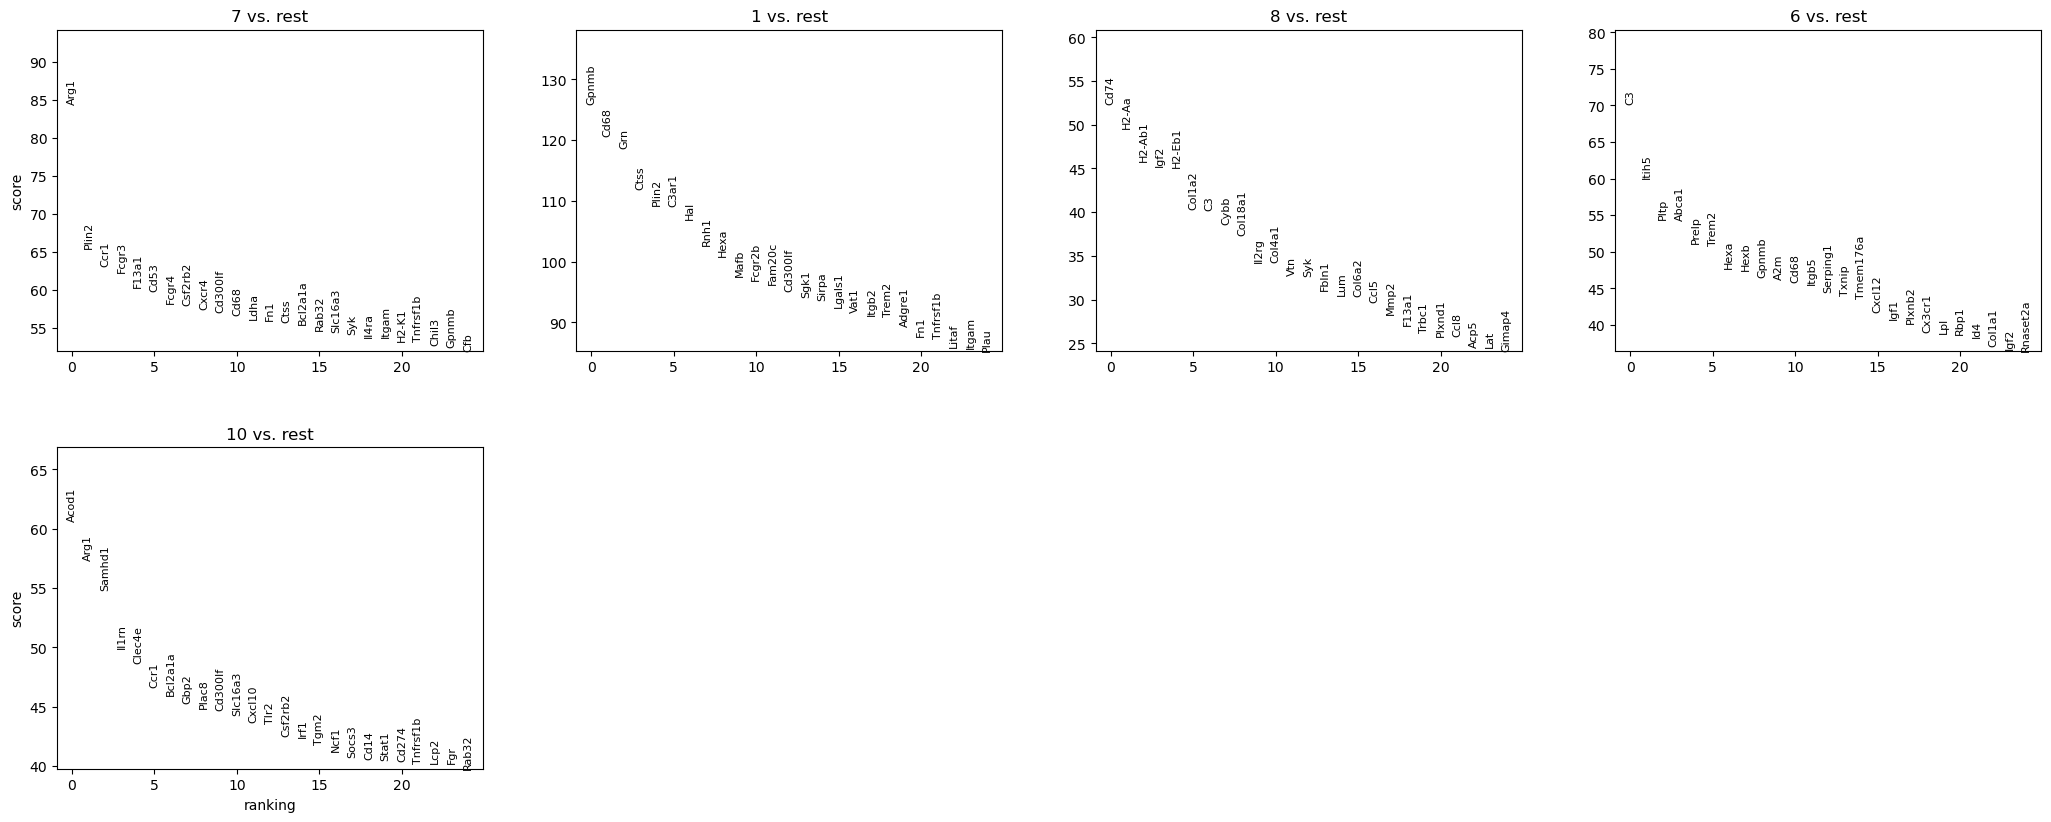

7
Arg1 Plin2 Ccr1 Fcgr3 F13a1 Cd53 Fcgr4 Csf2rb2 Cxcr4 Cd300lf Cd68 Ldha Fn1 Ctss Bcl2a1a Rab32 Slc16a3 Syk Il4ra Itgam H2-K1 Tnfrsf1b Chil3 Gpnmb Cfb Cybb Itgb2 Cxcl16 Hmox1 Samhd1
 
1
Gpnmb Cd68 Grn Ctss Plin2 C3ar1 Hal Rnh1 Hexa Mafb Fcgr2b Fam20c Cd300lf Sgk1 Sirpa Lgals1 Vat1 Itgb2 Trem2 Adgre1 Fn1 Tnfrsf1b Litaf Itgam Plau Cd53 Msn Cd84 Hexb Lamp1
 
8
Cd74 H2-Aa H2-Ab1 Igf2 H2-Eb1 Col1a2 C3 Cybb Col18a1 Il2rg Col4a1 Vtn Syk Fbln1 Lum Col6a2 Ccl5 Mmp2 F13a1 Trbc1 Plxnd1 Ccl8 Acp5 Lat Gimap4 Ciita Hal Abca1 Aldh1a2 Igkc
 
6
C3 Itih5 Pltp Abca1 Prelp Trem2 Hexa Hexb Gpnmb A2m Cd68 Itgb5 Serping1 Txnip Tmem176a Cxcl12 Igf1 Plxnb2 Cx3cr1 Lpl Rbp1 Id4 Col1a1 Igf2 Rnaset2a Adgre1 Lamp1 Blnk Ctss Axl
 
10
Acod1 Arg1 Samhd1 Il1rn Clec4e Ccr1 Bcl2a1a Gbp2 Plac8 Cd300lf Slc16a3 Cxcl10 Tlr2 Csf2rb2 Irf1 Tgm2 Ncf1 Socs3 Cd14 Stat1 Cd274 Tnfrsf1b Lcp2 Fgr Rab32 Ccl2 Oasl2 Psmb8 Tnfaip3 Iqgap1
 


In [471]:
import scanpy as sc

key = "MANA_cluster"              # <-- change to your cluster column
groups = ['7','1','8','6','10']          # <-- your three cluster labels (strings)

sc.tl.rank_genes_groups(
    ad_sub,
    groupby=key,
    groups=groups,
    reference="rest",             # each group vs all other cells
    method="wilcoxon",
    pts=True,                     # add fraction expressing
)
sc.pl.rank_genes_groups(ad_sub, n_genes=25, sharey=False)

marker_genes = pd.DataFrame({
    group: ad_sub.uns['rank_genes_groups']['names'][group][:30]
    for group in ad_sub.uns['rank_genes_groups']['names'].dtype.names
})
for col in marker_genes.columns: 
    print(col)
    genes = marker_genes[col].tolist()
    print(" ".join(genes))
    print(' ')

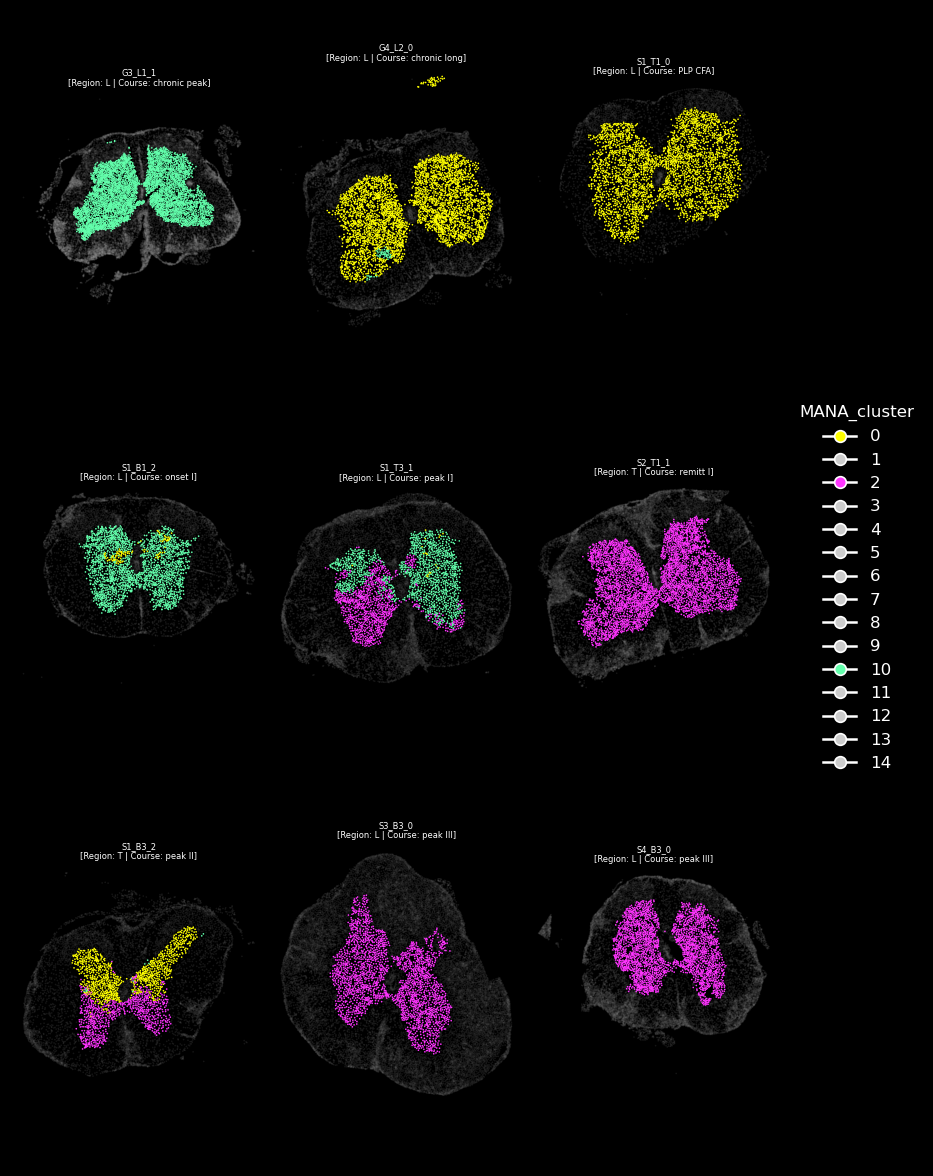

In [416]:
# usage
plot_spatial_compact_fast(
    ad_sub,
    color="MANA_cluster",
    groupby="sample_id",
    spot_size=1,
    cols=3,
    height=10,
    legend_col_width=1.0,
    background="black",
    grey_alpha=0.1,
    highlight=["0", "10", "2"]
)

In [ ]:
import scanpy as sc

key = "MANA_cluster"              # <-- change to your cluster column
groups = ["0", "10", "2"]          # <-- your three cluster labels (strings)

sc.tl.rank_genes_groups(
    ad_sub,
    groupby=key,
    groups=groups,
    reference="rest",             # each group vs all other cells
    method="wilcoxon",
    pts=True,                     # add fraction expressing
)
sc.pl.rank_genes_groups(ad_sub, n_genes=25, sharey=False)

In [28]:
ad_sub.write('../data/cellcharter.h5ad')